#"Do the best you can until you know better. Then when you know better, do better."

# Transfer Learning with TensorFlow Part 1: Feature Extraction

Transfer learning is leveraging a working model's existing architecture and learned patterns for our own problem.

There are two main benefits:
1. Can leverage an existing neural network architecture proven to work on problems similar to our own.
2. Can leverage a working neural network architecture wich has already learned patterns on similar data to our own, then we can adapt those patterns to our own data.

In [24]:
# Are we using a GPU?
!nvidia-smi

Sat Aug 20 21:49:59 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    30W /  70W |   8958MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Download and becoming one with the data

In [25]:
# Get the data (10% of 10 food classes from Food101) - https://www.kagge.com/dansbecker/food-101
import zipfile

# Download the data
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

# Unzip the downloaded the file
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip")
zip_ref.extractall()
zip_ref.close()

--2022-08-20 21:50:00--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.194.128, 173.194.195.128, 173.194.196.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip.1’

10_food_classes_10_ 100%[===================>] 160.74M   189MB/s    in 0.8s    

2022-08-20 21:50:01 (189 MB/s) - ‘10_food_classes_10_percent.zip.1’ saved [168546183/168546183]



In [26]:
# How many images in each folder?
import os

# Walk through 10 percent data directory and list number of files
for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '10_food_classes_10_percent'.
There are 10 directories and 0 images in '10_food_classes_10_percent/test'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/steak'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/grilled_salmon'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/fried_rice'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_wings'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/sushi'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/hamburger'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/chicken_curry'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/pizza'.
There are 0 directories and 250 images in '10_food_classes_10_percent/test/ramen'.
There are 0 directories and 250 images in '10_food_classes_10_percent/tes

## Creating data loaders (preparing the data)
We'll ise the `ImageDataGenerator` class to load in our images in batches.

In [27]:
# Setup data inputs
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Setup global variables (capitals = hyperparameter that's gonna be used somewhere else)
IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

# Setup directories
train_dir= "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

# Rescale
train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_10_percent = train_datagen.flow_from_directory(train_dir,
                                                          target_size=IMAGE_SHAPE,
                                                          batch_size=BATCH_SIZE,
                                                          class_mode="categorical") # categorical for multiclass classification, binary for two classes

print("Testing images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=IMAGE_SHAPE,
                                             batch_size=BATCH_SIZE,
                                             class_mode="categorical")

Training images:
Found 750 images belonging to 10 classes.
Testing images:
Found 2500 images belonging to 10 classes.


## Setting up callbacks (things to run whilst our model trains)

Callbacks are extra functionality you can add to your models to be performed during or after training. Some of the most popular callbacks:

* Tracking expirements with the `TensorBoard` callback
* Model checkpoint with `ModelCheckpoint`callback
* Stopping a model from training (before it trains to long ad overfits) with the `EarlyStopping`callback

In [28]:
# Create TensorBoard callback (functionized because we need to create a new on for each model)
import datetime # for time and date

def create_tensorboard_callback(dir_name, experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

🔑**Note:** You can customize the directory where your TensorBoard logs (model training metrics) get saved to whatever you like. The `log_dir`parameter we've created above is only one option.

## Creating models using TensorFlow Hub

In the past we've used TensorFlow to create our own models layer by layer from scratch.

Now we're going to do a similar process, except the majority of our model's layers are ging to come from TensorFlow Hub.

We can access pretrained models on : [TensorFlowHub](https://tfhub.dev/)

Browsing the TensorFlow Hub page and sorting for image classification, we found the following feature vector model link: https://tfhub.dev/google/efficientnet/b0/feature-vector/1

In [29]:
# Let's compare the following two models
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/google/efficientnet/b0/feature-vector/1"

In [30]:
# Import dependencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [31]:
# Let's make a creat_model() function to create a model from a URL
def create_model(model_url, num_classes=10):
  """
  Takes a TensorFlow Hub Url and creates a Keras Sequential model with it.

  Args:
    model_url (str): A TensorFlow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to number of target classes, default 10.
  
  Returns:
    An uncompiled Keras Sequential model with model_url as feature extractor
    layer and Dense output laer with num_classes output neurons.
  """
  # Download the pretrained model and save it as a Keras layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freez the already learned patterns
                                           name="feature_extraction_layer",
                                           input_shape=IMAGE_SHAPE+(3,)) # hack to make IMAGE_SHAPE to (224, 224, 3)

  # Create our own model
  model = tf.keras.Sequential([
      feature_extractor_layer,
      layers.Dense(num_classes, activation="softmax", name="output_layer")
  ])

  return model


### Creating and testing ResNet TensorFlow Hub Feature Extraction model

In [32]:
# Create Resnet model
resnet_model = create_model(resnet_url,
                            num_classes=train_data_10_percent.num_classes)

In [33]:
train_data_10_percent.num_classes

10

In [34]:
resnet_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2048)             23564800  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                20490     
                                                                 
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [35]:
# Compile our ResNet model
resnet_model.compile(loss="categorical_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [36]:
# Fit the model
rensnet_history = resnet_model.fit(train_data_10_percent,
                                  epochs=5,
                                  steps_per_epoch=len(train_data_10_percent),
                                  validation_data=test_data,
                                  validation_steps=len(test_data),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2"
                                                                         )])                                 


Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20220820-215005
Epoch 1/5
24/24 [==============================] - 20s 705ms/step - loss: 2.0344 - accuracy: 0.3133 - val_loss: 1.2356 - val_accuracy: 0.6064
Epoch 2/5
24/24 [==============================] - 16s 698ms/step - loss: 0.9551 - accuracy: 0.7213 - val_loss: 0.8877 - val_accuracy: 0.7248
Epoch 3/5
24/24 [==============================] - 17s 732ms/step - loss: 0.6579 - accuracy: 0.8107 - val_loss: 0.7502 - val_accuracy: 0.7684
Epoch 4/5
24/24 [==============================] - 16s 678ms/step - loss: 0.5055 - accuracy: 0.8720 - val_loss: 0.6950 - val_accuracy: 0.7836
Epoch 5/5
24/24 [==============================] - 16s 671ms/step - loss: 0.4017 - accuracy: 0.9000 - val_loss: 0.6815 - val_accuracy: 0.7784


In [37]:
import matplotlib.pyplot as plt

In [38]:
# Let's create a function to plot our loss curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics

  Args:
    history: Tensorflow History object.
  
  Returns:
    Plots of training/validation loss accuracy metrics.
  """
  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  # Plot loss
  plt.plot(epochs, loss, label="training_loss")
  plt.plot(epochs, val_loss, label="validation_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label="training_accuracy")
  plt.plot(epochs, val_accuracy, label="val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend();

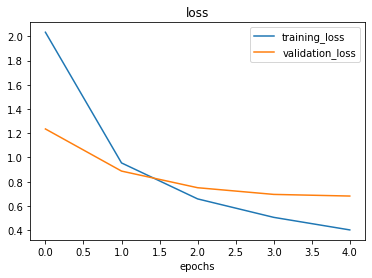

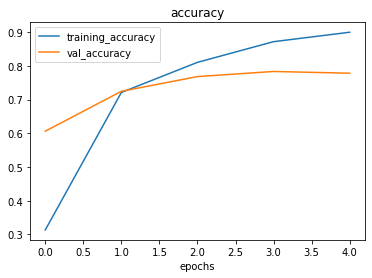

In [39]:
plot_loss_curves(rensnet_history)

### Creating and testing EfficentNetB0 TensorFlow Hub Feature Extraction model

In [40]:
# Create the model
efficenet_model = create_model(efficientnet_url,
                               num_classes=train_data_10_percent.num_classes)

In [41]:
efficenet_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 1280)             4049564   
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                12810     
                                                                 
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [42]:
# Compile the model
efficenet_model.compile(loss="categorical_crossentropy", # for multiclass classification
                        optimizer=tf.keras.optimizers.Adam(),
                        metrics=["accuracy"])

In [46]:
# Fit the model
efficenet_history = efficenet_model.fit(train_data_10_percent,
                                        epochs=15,
                                        steps_per_epoch=len(train_data_10_percent),
                                        validation_data=test_data,
                                        validation_steps=len(test_data),
                                        callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                               experiment_name="efficentNetB0 ")])

Saving TensorBoard log files to: tensorflow_hub/efficentNetB0 /20220820-221306
Epoch 1/15
24/24 [==============================] - 15s 642ms/step - loss: 0.4552 - accuracy: 0.9067 - val_loss: 0.5230 - val_accuracy: 0.8648
Epoch 2/15
24/24 [==============================] - 15s 639ms/step - loss: 0.3991 - accuracy: 0.9253 - val_loss: 0.4955 - val_accuracy: 0.8720
Epoch 3/15
24/24 [==============================] - 15s 645ms/step - loss: 0.3577 - accuracy: 0.9307 - val_loss: 0.4743 - val_accuracy: 0.8744
Epoch 4/15
24/24 [==============================] - 15s 647ms/step - loss: 0.3195 - accuracy: 0.9467 - val_loss: 0.4571 - val_accuracy: 0.8748
Epoch 5/15
24/24 [==============================] - 16s 668ms/step - loss: 0.2894 - accuracy: 0.9533 - val_loss: 0.4465 - val_accuracy: 0.8780
Epoch 6/15
24/24 [==============================] - 15s 631ms/step - loss: 0.2634 - accuracy: 0.9627 - val_loss: 0.4363 - val_accuracy: 0.8776
Epoch 7/15
24/24 [==============================] - 15s 635ms/s

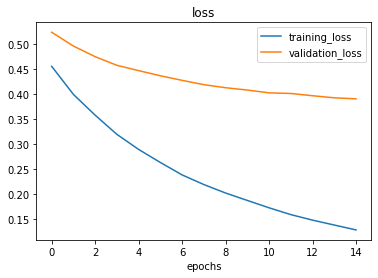

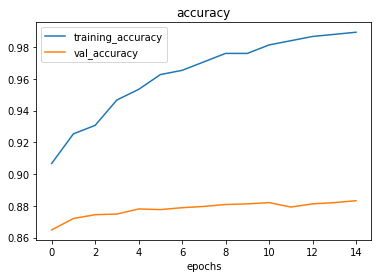

In [47]:
plot_loss_curves(efficenet_history)

### Creating and testing EfficentNetB7 TensorFlow Hub Feature Extraction model

In [50]:
efficenetb7_url = "https://tfhub.dev/tensorflow/efficientnet/b7/feature-vector/1"

In [51]:
#Create the model
efficenetb7_model = create_model(efficenetb7_url,
                                 num_classes=train_data_10_percent.num_classes)
# Compile the model
efficenetb7_model.compile(loss="categorical_crossentropy",
                          optimizer=tf.keras.optimizers.Adam(),
                          metrics=["accuracy"])
# Fit the model
b7_history = efficenetb7_model.fit(train_data_10_percent,
                                   epochs=5,
                                   steps_per_epoch=len(train_data_10_percent),
                                   validation_data=test_data,
                                   validation_steps=len(test_data),
                                   callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                          experiment_name="efficientnetb7")])

Saving TensorBoard log files to: tensorflow_hub/efficientnetb7/20220820-223223
Epoch 1/5
24/24 [==============================] - 67s 2s/step - loss: 1.5772 - accuracy: 0.5813 - val_loss: 0.9644 - val_accuracy: 0.7816
Epoch 2/5
24/24 [==============================] - 37s 2s/step - loss: 0.7873 - accuracy: 0.8147 - val_loss: 0.6716 - val_accuracy: 0.8252
Epoch 3/5
24/24 [==============================] - 36s 2s/step - loss: 0.5812 - accuracy: 0.8587 - val_loss: 0.5738 - val_accuracy: 0.8444
Epoch 4/5
24/24 [==============================] - 37s 2s/step - loss: 0.4807 - accuracy: 0.8773 - val_loss: 0.5288 - val_accuracy: 0.8524
Epoch 5/5
24/24 [==============================] - 37s 2s/step - loss: 0.4090 - accuracy: 0.9133 - val_loss: 0.5004 - val_accuracy: 0.8536


In [52]:
efficenetb7_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (K  (None, 2560)             64097680  
 erasLayer)                                                      
                                                                 
 output_layer (Dense)        (None, 10)                25610     
                                                                 
Total params: 64,123,290
Trainable params: 25,610
Non-trainable params: 64,097,680
_________________________________________________________________


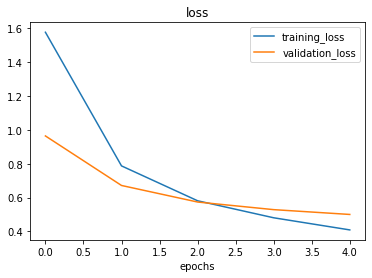

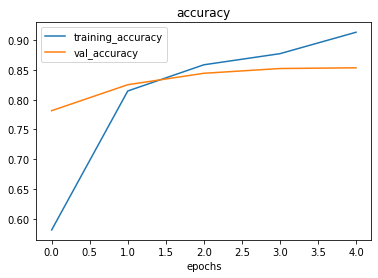

In [53]:
plot_loss_curves(b7_history)